In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

[ Info: Precompiling StockFlow [58c4a0e8-2944-4d18-9fa2-e17726aee9e5]


In [2]:
# Functions for graphing typed Petri nets
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series
colors_p = ["gold","gold4","darkorange1","lightgoldenrod","goldenrod"] # yellow and orange

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_parameter(typed_StockFlow::ACSetTransformation, colors) = 
(p, pp) -> ("p$pp", Attributes(:label=>pname(p,pp) isa Tuple where T ? Html(replace(string(pname(p,pp)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(pname(p,pp))",
                                     :shape=>"circle", 
                                     :color=>colors[typed_StockFlow[:P](pp)],
                                     :fontcolor=>colors[typed_StockFlow[:P](pp)]))

def_auxiliaryVF(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>make_v_expr(p,v) isa Tuple where T ? Html(replace(string(make_v_expr(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(make_v_expr(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:V](v)]))


def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

GraphF_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_p = colors_p, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = GraphF(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryVF(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),make_parameter=def_parameter(typed_StockFlow, colors_p),schema=schema, type=type, rd=rd
)
            
flatten(k::Nothing) = "nothing"
            
            

flatten (generic function with 3 methods)

In [37]:
seir = @stock_and_flow begin
    :stocks
    S
    E
    I
    R

    :parameters
    μ
    β
    tlatent
    trecovery
    δ
    c

    :dynamic_variables
    v_birth = μ * N
    v_inf = E / tlatent
    v_deathE = E * δ
    v_rec = I / trecovery
    v_deathI = I * δ
    v_deathR = R * δ
    v_deathS = S * δ
    
    v_prevalence = I / N
    v_meanInfectiousContactsPerS = c * v_prevalence
    v_perSIncidenceRate = β * v_meanInfectiousContactsPerS
    v_newInfections = S * v_perSIncidenceRate




    :flows
    CLOUD => f_birth(v_birth) => S
    S => f_incid(v_newInfections) => E
    S => f_deathS(v_deathS) => CLOUD
    E => f_inf(v_inf) => I
    E => f_deathE(v_deathE) => CLOUD
    I => f_rec(v_rec) => R
    I => f_deathI(v_deathI) => CLOUD
    R => f_deathR(v_deathR) => CLOUD

    :sums
    N = [S, E, I, R]
    NI = [I]
    NS = [S, E]

end;




In [35]:
seir = map(seir, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

In [39]:
open_seir = Open(seir,
    foot(:S,:N,:S=>:N),
    foot(:S,:NS,:S=>:NS));

In [40]:
open_seir = map(open_seir, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

LoadError: MethodError: no method matching map(::StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, Multicospan{StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Vararg{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, UnitRange{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, 9}}}, StockAndFlowF, StockAndFlowF}, StaticArraysCore.SVector{2, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Vararg{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, UnitRange{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, 9}}}, StockAndFlowF, StockAndFlowF}}}, StaticArraysCore.SVector{2, StockAndFlow0}}; Name::var"#38#41", Op::var"#39#42", Position::var"#40#43")

[0mClosest candidates are:
[0m  map(::Any, [91m::LinearAlgebra.Adjoint{T, <:AbstractVector} where T...[39m)[91m got unsupported keyword arguments "Name", "Op", "Position"[39m
[0m[90m   @[39m [36mLinearAlgebra[39m [90m/julia-1.9.0/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4madjtrans.jl:368[24m[39m
[0m  map(::Any, [91m::LinearAlgebra.Transpose{T, <:AbstractVector} where T...[39m)[91m got unsupported keyword arguments "Name", "Op", "Position"[39m
[0m[90m   @[39m [36mLinearAlgebra[39m [90m/julia-1.9.0/share/julia/stdlib/v1.9/LinearAlgebra/src/[39m[90m[4madjtrans.jl:369[24m[39m
[0m  map(::Any, [91m::AbstractSet[39m)[91m got unsupported keyword arguments "Name", "Op", "Position"[39m
[0m[90m   @[39m [90mBase[39m [90m[4mabstractarray.jl:3292[24m[39m
[0m  ...


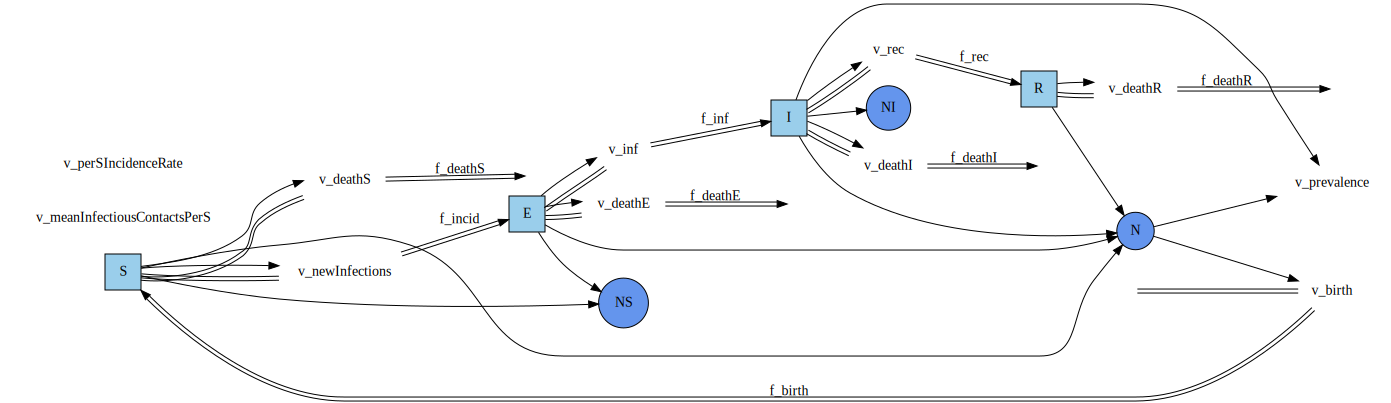

In [4]:
Graph(seir)

In [9]:
S, E, I, R = parts(seir, :S)
N, NI, NS = parts(seir, :SV)
ls_S_N, ls_S_NS, ls_E_N, ls_E_NS, ls_I_N, ls_I_NI, ls_R_N = parts(seir, :LS)
f_birth, f_incid, f_deathS, f_inf, f_deathE, f_rec, f_deathI, f_deathR = parts(seir, :F)
i_birth, i_incid, i_inf, i_rec = parts(seir, :I)
o_incid, o_deathS, o_inf, o_deathE, o_rec, o_deathI, o_deathR = parts(seir, :O)
v_birth, v_inf, v_deathE, v_rec, v_deathI, v_deathR, v_deathS, v_prevalence, v_meanInfectiousContactsPerS, v_perSIncidenceRate, v_newInfections = parts(seir, :V)
lv_inf, lv_deathE, lv_rec, lv_deathI, lv_deathR, lv_deathS, lv_prevalence, lv_newInfections = parts(seir, :LV)
lsv_births, lsv_prevalence = parts(seir, :LSV)
μ, β, tlatent, trecovery, δ, c = parts(seir, :P)
lvv_prevalence, lvv_meanInfectiousContactsPerS, lvv_perSIncidenceRate = parts(seir, :LVV)
lpv_birth, lpv_inf, lpv_deathE, lpv_rec, lpv_deathI, lpv_deathR, lpv_deathS, lpv_meanInfectiousContactsPerS, perSIncidenceRate = parts(seir, :LPV)


1:9

In [10]:
seir = map(seir, Name=name->nothing, Op=op->nothing, Position=pos->nothing);

In [26]:
seirf = @stock_and_flow begin
    :stocks
    Sf
    Ef
    If
    Rf

    :parameters
    μf
    βf
    tlatentf
    trecoveryf
    δf
    cf

    :dynamic_variables
    v_birthf = μf * Nf
    v_inff = Ef / tlatentf
    v_deathEf = Ef * δf
    v_recf = If / trecoveryf
    v_deathIf = If * δf
    v_deathRf = Rf * δf
    v_deathSf = Sf * δf
    
    v_prevalencef = If / Nf
    v_meanInfectiousContactsPerSf = cf * v_prevalencef
    v_perSIncidenceRatef = βf * v_meanInfectiousContactsPerSf
    v_newInfectionsf = Sf * v_perSIncidenceRatef

    :flows
    CLOUD => f_birthf(v_birthf) => Sf
    Sf => f_incidf(v_newInfectionsf) => Ef
    Sf => f_deathSf(v_deathSf) => CLOUD
    Ef => f_inff(v_inff) => If
    Ef => f_deathEf(v_deathEf) => CLOUD
    If => f_recf(v_recf) => Rf
    If => f_deathIf(v_deathIf) => CLOUD
    Rf => f_deathRf(v_deathRf) => CLOUD

    :sums
    Nf = [Sf, Ef, If, Rf]
    NIf = [If]
    NSf = [Sf, Ef]

end

open_seirf = Open(seirf,
    foot(:Sf,:Nf,:Sf=>:Nf),
    foot(:Sf,:NSf,:Sf=>:NSf),
    foot((),:NIf,())
)



StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, SMulticospan{3, StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Cate

In [24]:
seirm = @stock_and_flow begin
    :stocks
    Sm
    Em
    Im
    Rm

    :parameters
    μm
    βm
    tlatentm
    trecoverym
    δm
    cm

    :dynamic_variables
    v_birthm = μm * Nm
    v_infm = Em / tlatentm
    v_deathEm = Em * δm
    v_recm = Im / trecoverym
    v_deathIm = Im * δm
    v_deathRm = Rm * δm
    v_deathSm = Sm * δm
    
    v_prevalencem = Im / Nm
    v_meanInfectiousContactsPerSm = cm * v_prevalencem
    v_perSIncidenceRatem = βm * v_meanInfectiousContactsPerSm
    v_newInfectionsm = Sm * v_perSIncidenceRatem

    :flows
    CLOUD => f_birthm(v_birthm) => Sm
    Sm => f_incidm(v_newInfectionsm) => Em
    Sm => f_deathSm(v_deathSm) => CLOUD
    Em => f_infm(v_infm) => Im
    Em => f_deathEm(v_deathEm) => CLOUD
    Im => f_recm(v_recm) => Rm
    Im => f_deathIm(v_deathIm) => CLOUD
    Rm => f_deathRm(v_deathRm) => CLOUD

    :sums
    Nm = [Sm, Em, Im, Rm]
    NIm = [Im]
    NSm = [Sm, Em]

end


open_seirm = Open(seirm,
    foot(:Sm,:Nm,:Sm=>:Nm),
    foot(:Sm,:NSm,:Sm=>:NSm),
    foot((),:NIm,()))

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{StockAndFlow0, StockAndFlowF}, SMulticospan{3, StockAndFlowF, StructTightACSetTransformation{TypeLevelBasicSchema{Symbol, Tuple{:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV}, Tuple{(:lss, :LS, :S), (:lssv, :LS, :SV), (:ifn, :I, :F), (:is, :I, :S), (:ofn, :O, :F), (:os, :O, :S), (:fv, :F, :V), (:lvs, :LV, :S), (:lvv, :LV, :V), (:lsvsv, :LSV, :SV), (:lsvv, :LSV, :V), (:lvsrc, :LVV, :V), (:lvtgt, :LVV, :V), (:lpvp, :LPV, :P), (:lpvv, :LPV, :V)}, Tuple{:Name, :Op, :Position}, Tuple{(:sname, :S, :Name), (:svname, :SV, :Name), (:fname, :F, :Name), (:vname, :V, :Name), (:pname, :P, :Name), (:vop, :V, :Op), (:lvsposition, :LV, :Position), (:lsvsvposition, :LSV, :Position), (:lvsrcposition, :LVV, :Position), (:lpvpposition, :LPV, :Position)}}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV, :P, :LVV, :LPV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.Cate

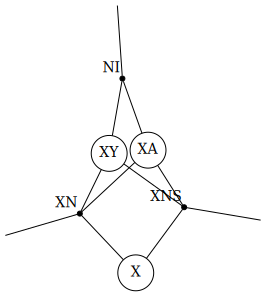

In [28]:
# define the UWD-algebra
uwd = @relation (XN,XNS,NI) begin
    X(XN,XNS)
    XA(XN,XNS,NI)
    XY(XN,XNS,NI)
end
display_uwd(uwd)

In [34]:
 oapply(uwd,Dict(
    :X=>open_seir,
    :XA=>open_seirm,
    :XY=>open_seirf
    ))

LoadError: Feet of cospans are not equal: StockAndFlow0:
  S = 1:1
  SV = 1:1
  LS = 1:1
  lss : LS → S = [1]
  lssv : LS → SV = [1]
  sname : S → Name = [:Sm]
  svname : SV → Name = [:Nm] != StockAndFlow0:
  S = 1:1
  SV = 1:1
  LS = 1:1
  lss : LS → S = [1]
  lssv : LS → SV = [1]
  sname : S → Name = [:S]
  svname : SV → Name = [:N]

In [16]:
sex = @stock_and_flow begin
    :stocks
    X
    
    :parameters
    μ
    δ
    rage
    
    :dynamic_variables
    v_births = μ * N
    v_deaths = δ * X
#     v_aging = rage * X
    
    :flows
    CLOUD => f_births(v_births) => X
#     X => f_aging(v_aging) => X
    X => f_deaths(v_deaths) => CLOUD
    
    :sums
    N = [X]
    NS = [X]
    NI = []
   
end

Any[:(:stocks), :X, :(:parameters), :μ, :δ, :rage, :(:dynamic_variables), :(v_births = μ * N), :(v_deaths = δ * X), :(:flows), :(CLOUD => (f_births(v_births) => X)), :(X => (f_deaths(v_deaths) => CLOUD)), :(:sums), :(N = [X]), :(NS = [X]), :(NI = [])]


StockAndFlowF with elements S = 1:1, SV = 1:3, LS = 1:2, F = 1:2, I = 1:1, O = 1:1, V = 1:2, LV = 1:1, LSV = 1:1, P = 1:3, LVV = 1:0, LPV = 1:2
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     X │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │     NS │
│  3 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    2 │
└────┴─────┴──────┘
┌───┬────┬──────────┐
│ F │ fv │    fname │
├───┼────┼──────────┤
│ 1 │  1 │ f_births │
│ 2 │  2 │ f_deaths │
└───┴────┴──────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
└───┴─────┴────┘
┌───┬──────────┬─────┐
│ V │    vname │ vop │
├───┼──────────┼─────┤
│ 1 │ v_births │   * │
│ 2 │ v_deaths │   * │
└───┴──────────┴─────┘
┌────┬─────┬─────┬─────────────┐
│ LV │ lvs │ lvv │ lvsposition │
├────┼─────┼─────┼─────────────┤
│  1 │   1 │   2 │           2 │
└────┴─────┴─────┴─────────────┘
┌─────┬───────┬──────┬───────────────┐
│ LSV │ lsvsv │ lsvv │ lsvsvposition │
├─────┼───────┼──────┼───────────────┤
│   1 │     1 │    1 │             2 │
└─────┴───────┴──────┴───────────────┘
┌───┬───────┐
│ P │ pname │
├───┼───────┤
│ 1 │     μ │
│ 2 │     δ │
│ 3 │  rage │
└───┴───────┘
┌─────┬──────┬──────┬──────────────┐
│ LPV │ lpvp │ lpvv │ lpvpposition │
├─────┼──────┼──────┼──────────────┤
│   1 │    1 │    1 │            1 │
│   2 │    2 │    2 │            1 │
└─────┴──────┴──────┴──────────────┘

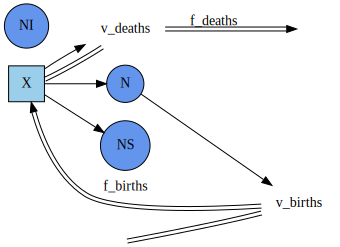

In [19]:
Graph(sex)